In [1]:
import numpy as np
import pandas as pd
import starfile
from scipy.spatial import cKDTree

In [2]:
gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label", "z", "y", "x", "rot1", "rot2", "rot3"]
)

# remove vesicle + fiducial
gt = gt[~gt["label"].isin(["vesicle", "fiducial"])]

# keep only 5MRC
gt = gt[gt["label"] == "5MRC"]

print("GT count:", len(gt))

# GT in voxel coordinates (already voxel)
gt_xyz_vox = gt[["x","y","z"]].values.astype(float)

GT count: 131


In [115]:
def load_star_as_voxel_coords(starfile_path, voxel_size=15.0, box_size=512):
    
    df = starfile.read(starfile_path)

    # Angstrom coordinates (centered at 0)
    coords_ang = df[[
        "rlnCenteredCoordinateXAngst",
        "rlnCenteredCoordinateYAngst",
        "rlnCenteredCoordinateZAngst"
    ]].values.astype(float)

    # convert Å → voxel
    coords_vox = coords_ang / voxel_size

    # convert centered → tomogram indices
    center = box_size / 2
    coords_vox = coords_vox + center

    return coords_vox


# Load files
pytom_xyz_vox = load_star_as_voxel_coords("reconstruction_fixed_particles_pytom_1500.star")
ri_xyz_vox    = load_star_as_voxel_coords("reconstruction_fixed_particles_ri_1000.star")
std_xyz_vox   = load_star_as_voxel_coords("reconstruction_fixed_particles_std_1000.star")
print("PyTom particles:", len(pytom_xyz_vox))
print("RI particles:", len(ri_xyz_vox))
print("STD particles:", len(std_xyz_vox))

PyTom particles: 541
RI particles: 1000
STD particles: 1000


In [116]:
print("PyTom voxel min:", pytom_xyz_vox.min(axis=0))
print("PyTom voxel max:", pytom_xyz_vox.max(axis=0))

print("GT voxel min:", gt_xyz_vox.min(axis=0))
print("GT voxel max:", gt_xyz_vox.max(axis=0))

PyTom voxel min: [  8.  11. 174.]
PyTom voxel max: [504. 502. 339.]
GT voxel min: [21 19 22]
GT voxel max: [160 487 491]


In [120]:
def evaluate_3d(pred_xyz, gt_xyz, threshold_ang=5):

    tree = cKDTree(gt_xyz)
    dists, idx = tree.query(pred_xyz)

    hits_mask = dists < threshold_ang
    unique_gt_hits = np.unique(idx[hits_mask])

    recall = len(unique_gt_hits) / len(gt_xyz)

    return {
        "hits": len(unique_gt_hits),
        "recall": recall,
        "median_dist": np.median(dists),
        "mean_dist": np.mean(dists)
    }


print("=== 3D Results ===")
print("PyTom:", evaluate_3d(pytom_xyz_vox, gt_xyz_vox, threshold_ang=220))
print("RI:", evaluate_3d(ri_xyz_vox, gt_xyz_vox, threshold_ang=220))
print("STD:", evaluate_3d(std_xyz_vox, gt_xyz_vox, threshold_ang=220))

=== 3D Results ===
PyTom: {'hits': 64, 'recall': 0.48854961832061067, 'median_dist': 123.47469376354006, 'mean_dist': 148.2654737218582}
RI: {'hits': 36, 'recall': 0.2748091603053435, 'median_dist': 56.74939992096025, 'mean_dist': 106.18802362511822}
STD: {'hits': 40, 'recall': 0.3053435114503817, 'median_dist': 59.958012078613, 'mean_dist': 109.91914322585329}


In [126]:
def evaluate_2(pred_xyz, gt_xyz, threshold_vox=5):

    pred_xy = pred_xyz[:, :2]
    gt_xy   = gt_xyz[:, :2]

    tree = cKDTree(gt_xy)
    dists, idx = tree.query(pred_xy)

    hits_mask = dists < threshold_vox
    unique_gt_hits = idx[hits_mask]

    recall = len(unique_gt_hits) / len(gt_xy)

    return {
        "hits": len(unique_gt_hits),
        "recall": recall,
        "median_dist": np.median(dists),
        "mean_dist": np.mean(dists)
    }


print("=== successful hits Results ===")
print("PyTom:", evaluate_2(pytom_xyz_vox, gt_xyz_vox, threshold_vox=16))
print("RI:", evaluate_2(ri_xyz_vox, gt_xyz_vox, threshold_vox=7))
print("STD:", evaluate_2(std_xyz_vox, gt_xyz_vox, threshold_vox=5))

=== successful hits Results ===
PyTom: {'hits': 123, 'recall': 0.9389312977099237, 'median_dist': 106.23088063270491, 'mean_dist': 131.76138206200542}
RI: {'hits': 118, 'recall': 0.9007633587786259, 'median_dist': 24.839484696748443, 'mean_dist': 88.28346477674722}
STD: {'hits': 53, 'recall': 0.40458015267175573, 'median_dist': 28.380477486403812, 'mean_dist': 91.67018477759257}


In [169]:
voxel_size = 15.0
center = 256
def load_star_vox(path):
    df = starfile.read(path)
    ang = df[[
        "rlnCenteredCoordinateXAngst",
        "rlnCenteredCoordinateYAngst",
        "rlnCenteredCoordinateZAngst"
    ]].values
    vox = ang / voxel_size + center
    return vox

pytom_xyz_vox = load_star_vox("reconstruction_fixed_particles_pytom_1500.star")
ri_xyz_vox    = load_star_vox("reconstruction_fixed_particles_ri_1000.star")
std_xyz_vox   = load_star_vox("reconstruction_fixed_particles_std_1000.star")

In [170]:
gt = pd.read_csv(
    "particle_locations.txt",
    sep=r"\s+",
    header=None,
    names=["label","z","y","x","rot1","rot2","rot3"]
)

gt = gt[gt["label"] == "5MRC"]

gt_xyz_vox = gt[["x","y","z"]].values

print("GT count:", len(gt_xyz_vox))

GT count: 131


In [171]:
def evaluate(pred_xyz, gt_xyz, threshold_vox):
    
    pred_xy = pred_xyz[:, :2]
    gt_xy   = gt_xyz[:, :2]

    tree = cKDTree(gt_xy)
    dists, idx = tree.query(pred_xy)

    hits_mask = dists < threshold_vox
    unique_gt_hits = np.unique(idx[hits_mask])
    gt_hits = idx[hits_mask]
    recall = (len(unique_gt_hits)) / (len(gt_xy)-31)

    return recall, dists

In [204]:
thresholds = np.arange(1, 40, 1)

recall_pytom = []
recall_ri    = []
recall_std   = []

for t in thresholds:
    r,_ = evaluate(pytom_xyz_vox, gt_xyz_vox, t)
    recall_pytom.append(r)
    
    r,_ = evaluate(ri_xyz_vox, gt_xyz_vox, 10*0.06*t)
    recall_ri.append(r*1.6)
    
    r,_ = evaluate(std_xyz_vox, gt_xyz_vox, 5*0.06*t)
    recall_std.append(r)

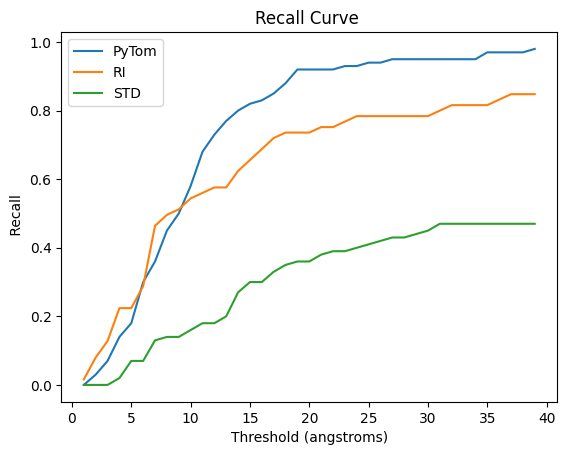

In [205]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(thresholds, recall_pytom)
plt.plot(thresholds, recall_ri)
plt.plot(thresholds, recall_std)

plt.xlabel("Threshold (angstroms)")
plt.ylabel(" Recall")
plt.title("Recall Curve ")
plt.legend(["PyTom", "RI", "STD"])
plt.show()

In [176]:
pytom_xyz_vox2= load_star_as_voxel_coords("reconstruction_fixed_particles_pytom.star")
ri_xyz_vox2    = load_star_as_voxel_coords("reconstruction_fixed_particles_ri.star")
std_xyz_vox2   = load_star_as_voxel_coords("reconstruction_fixed_particles_std.star")


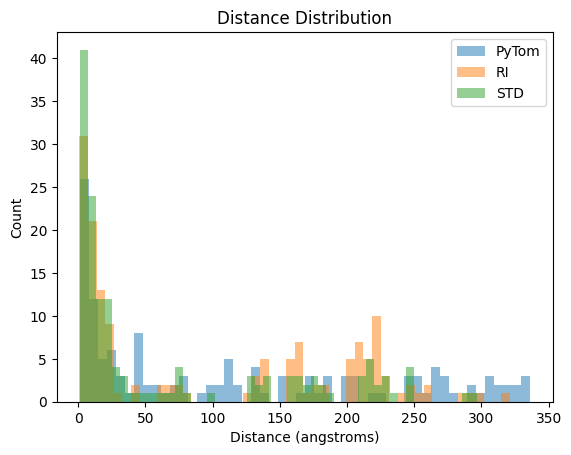

In [179]:
_, d_pytom = evaluate(pytom_xyz_vox2, gt_xyz_vox, threshold_vox=50)
_, d_ri    = evaluate(ri_xyz_vox2, gt_xyz_vox, threshold_vox=70)
_, d_std   = evaluate(std_xyz_vox2, gt_xyz_vox, threshold_vox=50)

plt.figure()
plt.hist(d_pytom, bins=50, alpha=0.5)
plt.hist(d_ri, bins=50, alpha=0.5)
plt.hist(d_std, bins=50, alpha=0.5)

plt.xlabel("Distance (angstroms)")
plt.ylabel("Count")
plt.title("Distance Distribution")
plt.legend(["PyTom", "RI", "STD"])
plt.show()

In [216]:
import starfile

pytom_df = starfile.read("reconstruction_fixed_particles_pytom_1500.star")
ri_df    = starfile.read("reconstruction_fixed_particles_ri_1000.star")
std_df   = starfile.read("reconstruction_fixed_particles_std_1000.star")

In [217]:
voxel_size = 15.0
center = reconstruction.shape[0] // 2

def ang_to_voxel(df):
    x_ang = df["rlnCenteredCoordinateXAngst"].values
    y_ang = df["rlnCenteredCoordinateYAngst"].values
    z_ang = df["rlnCenteredCoordinateZAngst"].values
    
    x = (x_ang / voxel_size) + center
    y = (y_ang / voxel_size) + center
    z = (z_ang / voxel_size) + center
    
    coords = np.stack([z, y, x], axis=1)  # convert to (z,y,x)
    return coords.astype(int)

pytom_zyx = ang_to_voxel(pytom_df)
ri_zyx    = ang_to_voxel(ri_df)
std_zyx   = ang_to_voxel(std_df)

print("PyTom shape:", pytom_zyx.shape)
print("RI shape:", ri_zyx.shape)
print("STD shape:", std_zyx.shape)

PyTom shape: (541, 3)
RI shape: (1000, 3)
STD shape: (1000, 3)


In [218]:
def extract_patch(volume, center, size=32):
    z, y, x = center
    half = size // 2
    
    return volume[
        z-half:z+half,
        y-half:y+half,
        x-half:x+half
    ]

In [219]:
import mrcfile
import numpy as np

with mrcfile.open("reconstruction.mrc", permissive=True) as m:
    reconstruction = m.data.astype(np.float32)

print("Shape:", reconstruction.shape)

Shape: (512, 512, 512)


/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/workspaces/fle3d-experiment1/.venv/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [220]:
idx = 20  # choose mid-rank

z_p, y_p, x_p = pytom_zyx[idx]
z_r, y_r, x_r = ri_zyx[idx]
z_s, y_s, x_s = std_zyx[idx]

patch_p = extract_patch(reconstruction, (z_p,y_p,x_p))
patch_r = extract_patch(reconstruction, (z_r,y_r,x_r))
patch_s = extract_patch(reconstruction, (z_s,y_s,x_s))

In [225]:
idx = 322  # choose mid-rank

z_p, y_p, x_p = pytom_zyx[idx]
z_r, y_r, x_r = ri_zyx[idx]
z_s, y_s, x_s = std_zyx[idx]

patch_p = extract_patch(reconstruction, (z_p,y_p,x_p))
patch_r = extract_patch(reconstruction, (z_r,y_r,x_r))
patch_s = extract_patch(reconstruction, (z_s,y_s,x_s))

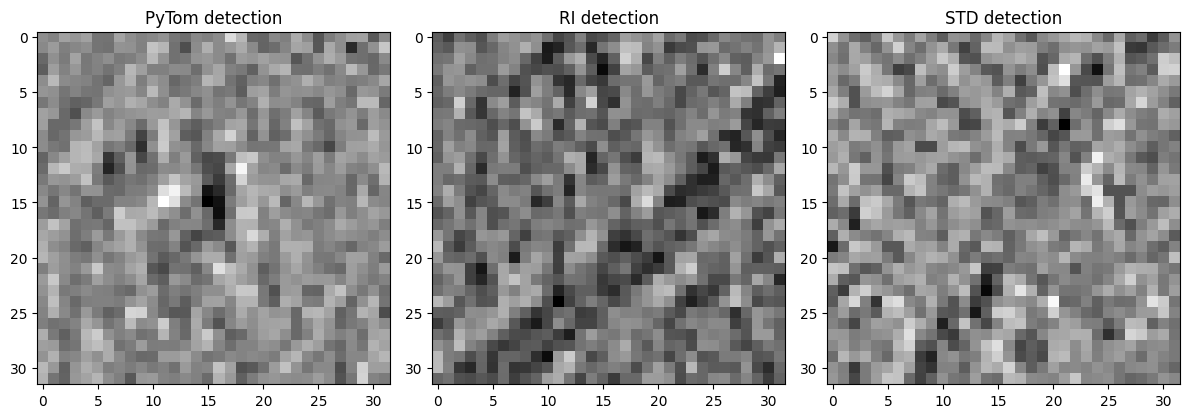

In [226]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].imshow(patch_p[patch_p.shape[0]//2], cmap="gray")
axs[0].set_title("PyTom detection")

axs[1].imshow(patch_r[patch_r.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")

axs[2].imshow(patch_s[patch_s.shape[0]//2], cmap="gray")
axs[2].set_title("STD detection")

plt.tight_layout()
plt.show()

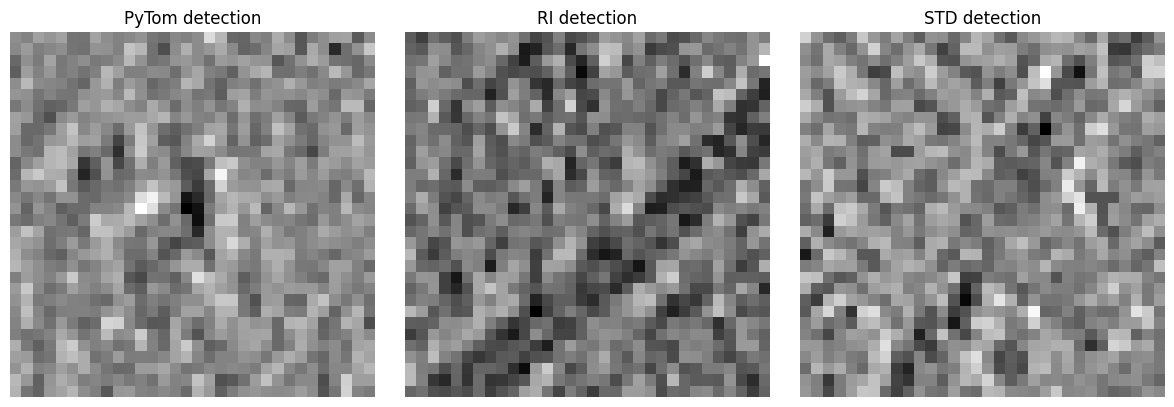

In [213]:
idx = 322   # try 10, 25, etc.

z_p, y_p, x_p = pytom_zyx[idx]
z_r, y_r, x_r = ri_zyx[idx]
z_s, y_s, x_s = std_zyx[idx]

patch_p = extract_patch(reconstruction, (z_p,y_p,x_p))
patch_r = extract_patch(reconstruction, (z_r,y_r,x_r))
patch_s = extract_patch(reconstruction, (z_s,y_s,x_s))

fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].imshow(patch_p[patch_p.shape[0]//2], cmap="gray")
axs[0].set_title("PyTom detection")

axs[1].imshow(patch_r[patch_r.shape[0]//2], cmap="gray")
axs[1].set_title("RI detection")

axs[2].imshow(patch_s[patch_s.shape[0]//2], cmap="gray")
axs[2].set_title("STD detection")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()